# Ultimate Take Home Challenge Part 1 - Exploratory Data Analysis

In [12]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

In [2]:
os.getcwd()

'C:\\Users\\adre9\\Springboard 2024\\Springboard_2024_GH\\Ultimate_challenge_3_\\ultimate_challenge'

In [4]:
# Load the JSON file
with open('logins.json', 'r') as file:
    data = json.load(file)

In [5]:
# Convert login time list into a df
login_times = pd.to_datetime(data['login_time'])
logins_df = pd.DataFrame({'login_time': login_times})

# Set login_time as index
logins_df.set_index('login_time', inplace=True)
logins_df.head()

""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:37
1970-01-01 20:16:36
1970-01-01 20:26:21


In [7]:
# 15-minute intervals
logins_15mins = logins_df.resample('15min').size()

logins_15mins.head()

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15min, dtype: int64

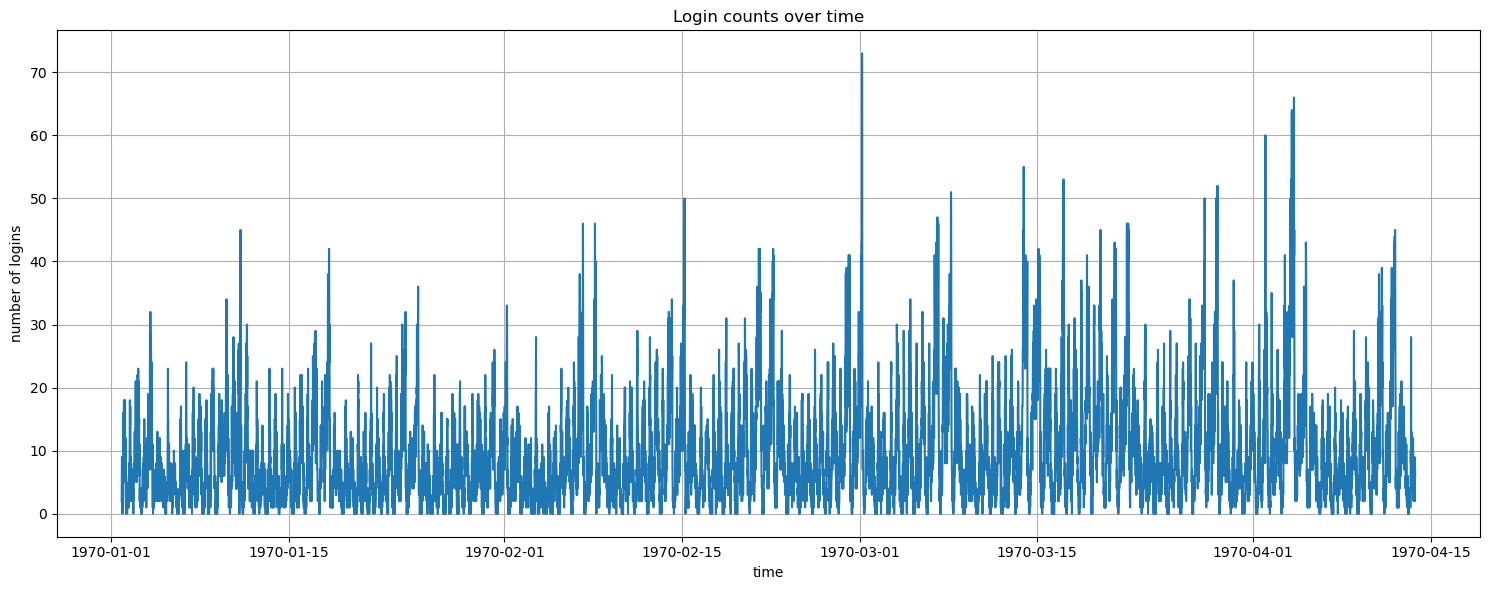

In [8]:
# Visualize the time series
plt.figure(figsize=(15,6))
plt.plot(logins_15mins.index, logins_15mins.values)
plt.title('Login counts over time')
plt.xlabel('time')
plt.ylabel('number of logins')
plt.tight_layout()
plt.grid(True)
plt.show()

Lots of fluctuations in activity -- some peaks and troughs that hint at possible usage patterns.

We will zoom in on login activities for a week and then a day.

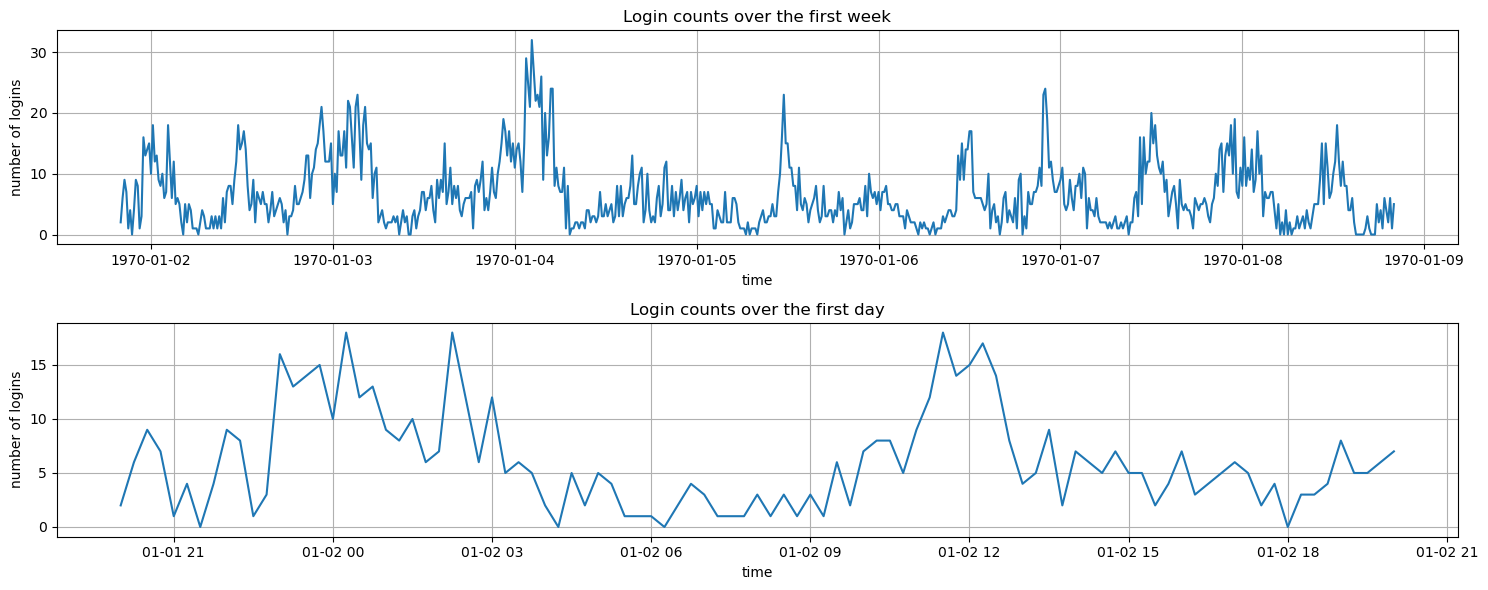

In [11]:
# First full week of data
start_week = logins_15mins.index.min()
end_week = start_week + pd.Timedelta(days=7)
login_week = logins_15mins.loc[start_week:end_week]

# First full day of data
end_day = start_week + pd.Timedelta(days=1)
login_day = logins_15mins.loc[start_week:end_day]

# Plots for both
fig, ax = plt.subplots(2,1, figsize=(15,6))

ax[0].plot(login_week.index, login_week.values)
ax[0].set_title("Login counts over the first week")
ax[0].set_xlabel("time")
ax[0].set_ylabel("number of logins")
ax[0].grid(True)

ax[1].plot(login_day.index, login_day.values)
ax[1].set_title("Login counts over the first day")
ax[1].set_xlabel("time")
ax[1].set_ylabel("number of logins")
ax[1].grid(True)

plt.tight_layout()
plt.show()

- **Week** plot shows that there are repreating daily patterns which suggests periods of higher/lower user activity.
- **Day** plot displays a clear intraday scycle -- likely reflecting peak usage hours.
- Peak hours look to be around midday and high activity between midnight and 3am.

Let's zoom out and quantify the patterns by seeing what the average logins are per day hour of the day and day of the week.

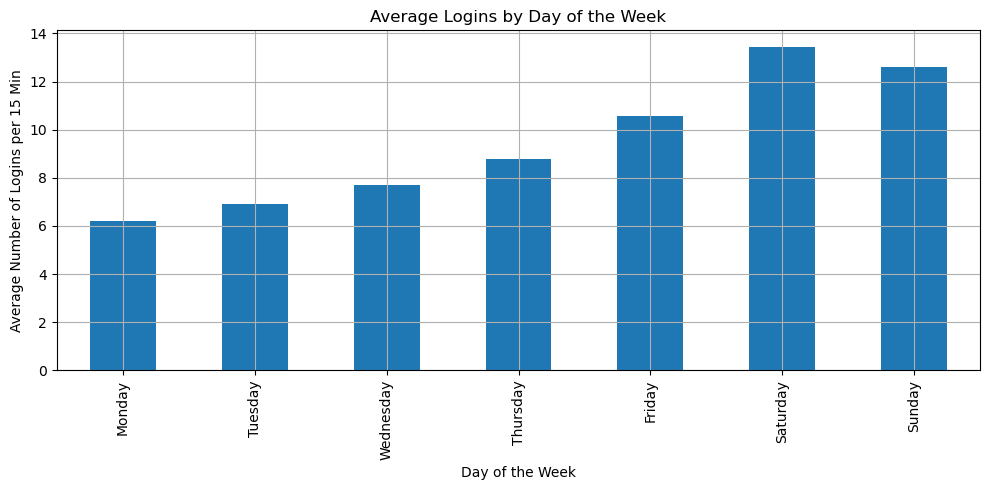

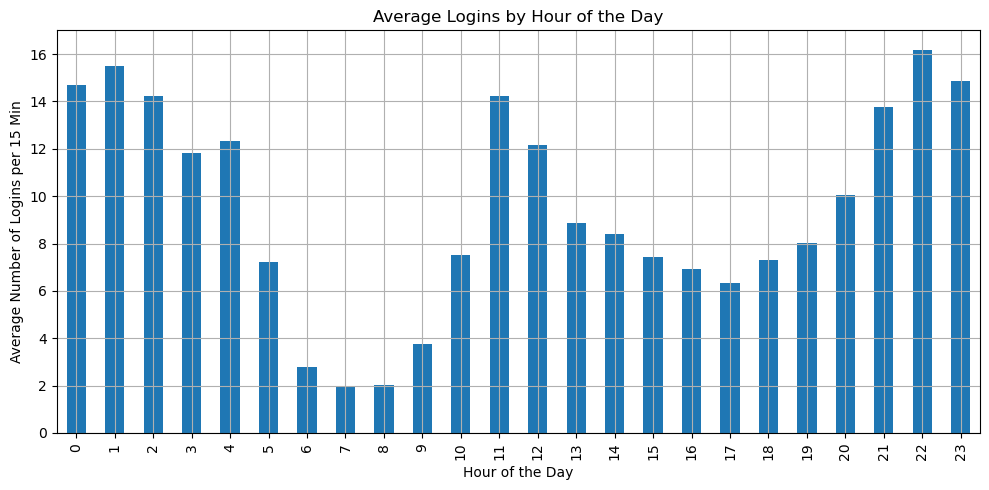

In [15]:
# Create a new DataFrame from the time series to extract day and hour info
df_patterns = logins_15mins.reset_index()
df_patterns['day_of_week'] = df_patterns['login_time'].dt.day_name()
df_patterns['hour_of_day'] = df_patterns['login_time'].dt.hour

# Average logins per day of the week
avg_by_day = df_patterns.groupby('day_of_week')[0].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Average logins per hour of the day
avg_by_hour = df_patterns.groupby('hour_of_day')[0].mean()

# Plot average logins per day of the week
plt.figure(figsize=(10, 5))
avg_by_day.plot(kind='bar')
plt.title('Average Logins by Day of the Week')
plt.ylabel('Average Number of Logins per 15 Min')
plt.xlabel('Day of the Week')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot average logins per hour of the day
plt.figure(figsize=(10, 5))
avg_by_hour.plot(kind='bar')
plt.title('Average Logins by Hour of the Day')
plt.ylabel('Average Number of Logins per 15 Min')
plt.xlabel('Hour of the Day')
plt.grid(True)
plt.tight_layout()
plt.show()

- **By day of the week** there looks to be higher login activity during the weekends.
- **By hour of the day** we see that there's a clear peak in the evening hours with a big dip in the morning hours.

Are there any anomalies that stand out?

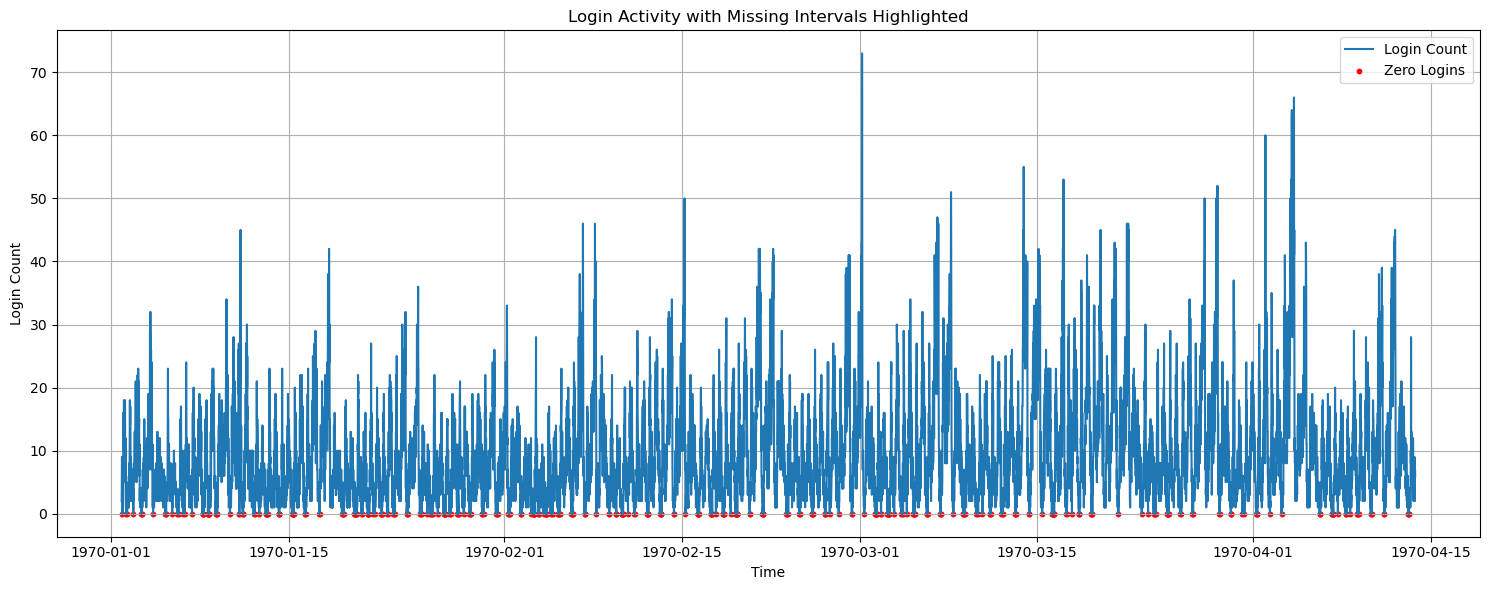

(407, 4.158152840212505)

In [18]:
# Reindex the series to ensure it includes every 15-minute interval in the time range
full_time_range = pd.date_range(
    start=logins_15mins.index.min(),
    end=logins_15mins.index.max(),
    freq='15min'
)

# Fill missing intervals with 0
login_counts_full = logins_15mins.reindex(full_time_range, fill_value=0)

# Find missing or unusually low activity intervals
missing_intervals = login_counts_full[login_counts_full == 0]

# Plot the full timeline with missing (zero-login) intervals highlighted
plt.figure(figsize=(15, 6))
plt.plot(login_counts_full.index, login_counts_full.values, label='Login Count')
plt.scatter(missing_intervals.index, [0]*len(missing_intervals), color='red', s=10, label='Zero Logins')
plt.title("Login Activity with Missing Intervals Highlighted")
plt.xlabel("Time")
plt.ylabel("Login Count")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# Number of missing intervals
num_missing = len(missing_intervals)
num_total = len(login_counts_full)
missing_pct = (num_missing / num_total) * 100

num_missing, missing_pct

- There are 407 missing intervals, which accounts for a little over 4% of the data.
- Zero-activity periods likely corresponds to the early morning hours, but also could be data outages, user inactivity patterns, or logging gaps.
- Are there any patterns as to when the zero-activity periods were?

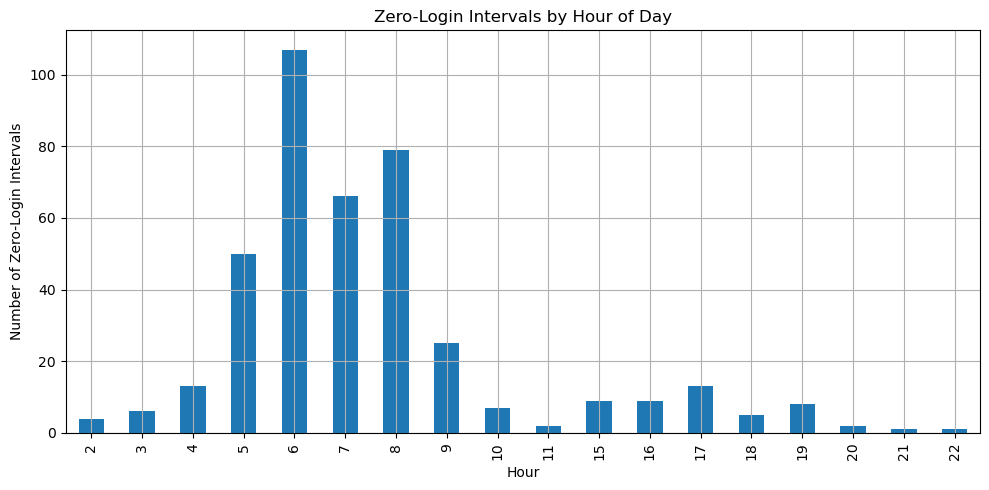

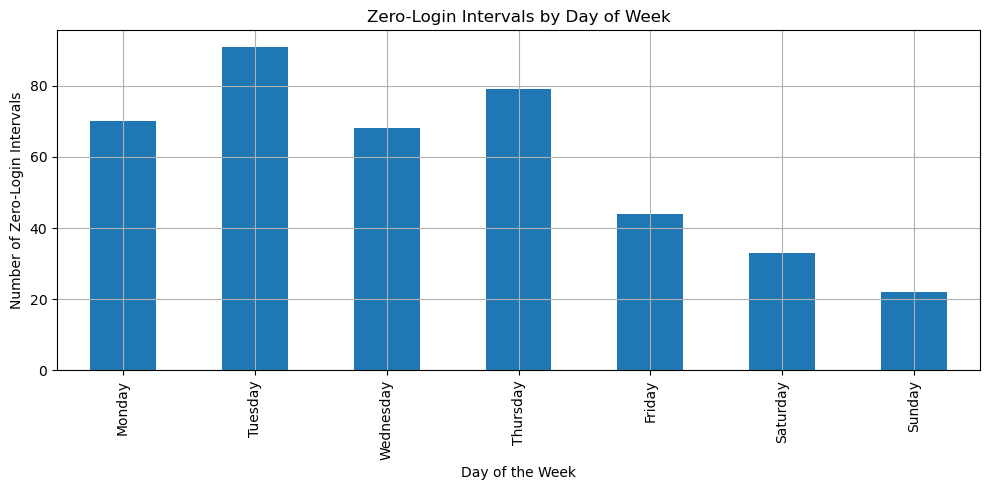

In [19]:
# DF for the missing intervals 
missing_df = pd.DataFrame({'timestamp': missing_intervals.index})
missing_df['day_of_week'] = missing_df['timestamp'].dt.day_name()
missing_df['hour'] = missing_df['timestamp'].dt.hour

# Count missing intervals by hour of the day
missing_by_hour = missing_df['hour'].value_counts().sort_index()

# Count missing intervals by day of the week
missing_by_day = missing_df['day_of_week'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot missing intervals by hour
plt.figure(figsize=(10, 5))
missing_by_hour.plot(kind='bar')
plt.title('Zero-Login Intervals by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Zero-Login Intervals')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot missing intervals by day
plt.figure(figsize=(10, 5))
missing_by_day.plot(kind='bar')
plt.title('Zero-Login Intervals by Day of Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Zero-Login Intervals')
plt.grid(True)
plt.tight_layout()
plt.show()

- Most of the missing activity aligns with what we saw on with the average login numbers during the same time period.
- During the week it seems fairly unifrom during the week days, while the zero-activity dips during the weekend.

The lack of logins looks to be more time-of-day driven than day of the week.

2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on

- a) How you will implement the experiment?
    - I would randomly select a subset of a few thousand driver-partners from each city, randomly placing half of them in either the:
        - **Treatment group** where they would receive a letter from their respective city with either a car sticker that will send the toll bill to the city to pay or a form for the drivers to fill out at the end of the expirement's timeframe to send back to the city with their collected toll bills so that the city could cut out the necessary checks.
          
          **or**
        - **Control group** of randomly selected drivers who's who won't receive toll reimbursements.
    - The **duration** of the experiment would last for 2-3 months to help capture variations in events, traffic, and weather activities. As well as detect sustained behavioral changes rather than short-term spikes.
    - We will track **data** such as bridge crossing data (via toll data, GPS, or app logs), time and direction of travel, driver IDs to associate with the groups, and city where the trip began and ended.
    - There should be **ethical considerations** such that the teatment group needs to be told that they are part of an experiment to induce behavior change, but to keep the control group in the dark to prevent contamination of the experiment.:

- b) What statistical test(s) you will conduct to verify the significance of the 
observatio?
    - This would be a **one-tailed**, **two-sample**, **t-test** to compare the average number of cross-city trips per driver between the treatment and control groups with a significance level of alpha = 0.05. 

- c) How you would interpret the results and provide recommendations to the city 
operations team along with any caveat?
    - If p < 0.05 then I would conclude that toll reimbursement positively impacts driver behavior and encourages greater mobility betweeen Gotham and Metropolis.
        - We'd expand to additional driver cohorts in both cities, monitor beidge traffic to adjust incentives, and possibly integrate app nudges to encourage off-peak cross-city trips to balance load. 
    - If p > 0.05 we won't conlude the program's ineffectiveness because it may mean the effect was too small to detect or obscured by other confounding variables like weather, holiday season, or local events like sports games or theatre performances.
    - Adjust the testing period to account for seasonality or other external influences, possibly do partial toll subsidies or time-of-the-day incentives (free crrossings at off-peak hours), or conduct follow-up surveys to understand driver behavior and perception.